# b) Clustering using Gaussian Mixture Model(GMM)

# Program 1 - Implementing GMM from scratch using expectation and maximization algorithm

# Part 1 - Defining the class for GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans as SklKMeans
class GMM:
    def __init__(self, 
        n_components: int, n_iters: int, tol: float,
        random_state: int=0, init_params="random"
    ):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.init_params = init_params
        self.random_state = random_state


    def fit(self, X,plot=False,plot_params={}):
        m,n= X.shape
        self.X = X
        k = self.n_components
        
        self.resp = np.zeros((m, k))
        self.weights = np.full(k, 1 / k)
        
        
        if self.init_params == "kmeans":
            kmeans = SklKMeans(k,random_state=self.random_state)
            kmeans.fit(X)
            self.means = kmeans.cluster_centers_
        if self.init_params == "random" :
            np.random.seed(self.random_state)
            self.means = X[np.random.choice(m, k , replace=False)]
            

        self.covs = np.full((k, n, n), np.cov(X, rowvar=False))
    
        self.converged = False
        self.log_likelihood_trace = []
        
        if plot:
            fig,ax = plt.subplots(1,4,figsize=(20,5))
            fig.suptitle("GMM Using Estimation and Maximization")
            self.draw(ax[0],"Initial Clusters", **plot_params)
        
        for i in range(self.n_iters):
            self._do_estep(X)
            self._do_mstep(X)
            self.log_likelihood_trace.append(self.log_likelihood)
            if i == 0:
                if plot:
                    self.draw(ax[1],"Clusters after 1 iteration", **plot_params)
            else:
                ol,nl = self.log_likelihood_trace[-2:]
                if nl-ol <= self.tol: 
                    self.converged = True
                    break
        if plot:
            self.draw(ax[2],f"clusters after {i+1} iterations", **plot_params)
            ax[3].plot(self.log_likelihood_trace, "-o")
            ax[3].set_title("Log Likelihood")
            plt.show()

    def _do_estep(self, X):
        for k in range(self.n_components):
            self.resp[:, k] = self.weights[k] * multivariate_normal(self.means[k], self.covs[k]).pdf(X)
        p_x = np.sum(self.resp, axis=1,keepdims=1)
        self.resp = self.resp / p_x
        self.log_likelihood = np.sum(np.log(p_x))
        
    def _do_mstep(self, X):
        resp_weights = self.resp.sum(axis=0)
        self.weights = resp_weights / X.shape[0]
        self.means = self.resp.T @ X/ resp_weights.reshape(-1, 1)
        diff = X[:,np.newaxis,:] - self.means
        self.covs = np.einsum('ik,ikj,ikl->kjl',self.resp,diff,diff)/resp_weights.reshape(-1,1,1)
        

    def draw(self,ax,  title="", **plot_params):
        ax.set_title(title)
        ax.scatter(self.X[:, 0], self.X[:, 1],**plot_params)
        
        delta = 0.05
        k = self.n_components
        x = np.arange(*ax.get_xlim(), delta)
        y = np.arange(*ax.get_ylim(), delta)
        x, y = np.meshgrid(x, y)
        col = [f"C{(i+1)%10}" for i in range(k)]
        for i in range(k):
            mean, cov = self.means[i], self.covs[i]
            z = multivariate_normal(mean, cov).pdf(np.dstack([x, y]))
            ax.scatter(mean[0], mean[1], color=col[i])
            ax.contour(x, y, z, levels=[.01], colors=col[i])

# Part 2 - Generating Random data from a Gaussian mixture

In [2]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10],seed = 1):
    np.random.seed(seed)
    x = np.ndarray((k,points_per_cluster,dim))
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = np.random.rand(dim, dim+10)
        cov = cov @ cov.T
        x[i] = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
    x = x.reshape(-1,dim)

    if(dim == 2):
        plt.figure()
        plt.title("generated random gaussian distributions")
        plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.4)
        plt.show()
        
    return x


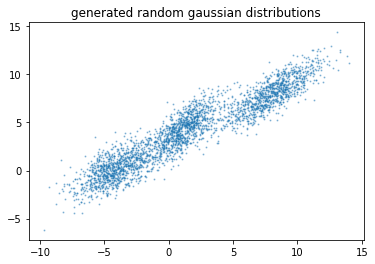

In [3]:
X = gen_data(k=3, dim=2, points_per_cluster=1000, seed=3)

# Part 3 - Implementing GMM on generated random data

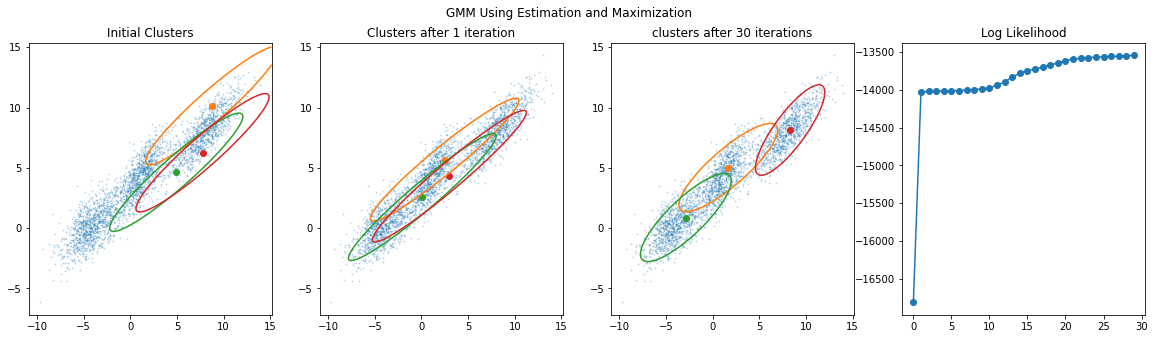

In [10]:
gmm = GMM(n_components = 3,n_iters = 30,tol = 10e-4,random_state = 5,init_params = "random")
gmm.fit(X,plot = True,plot_params = {"s":1,"alpha":.2})

# Part 4 - Implementing GMM by using Kmeans to initialize means

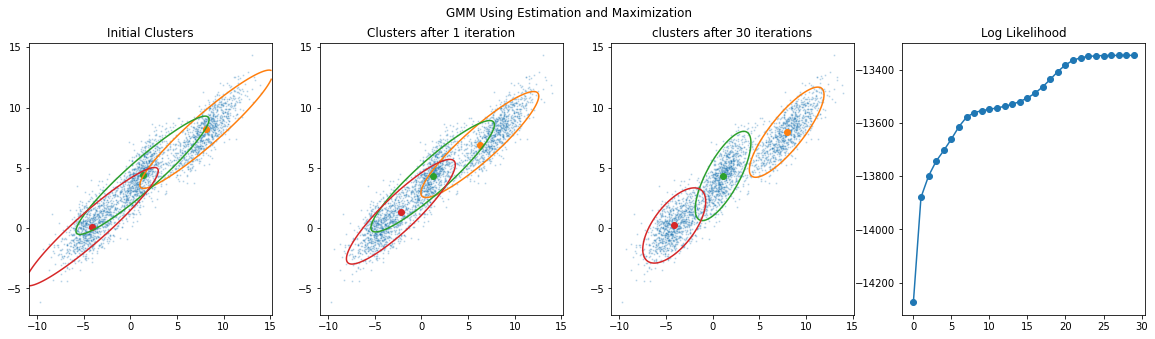

In [13]:
k = 3
gmm = GMM(n_components = k,n_iters = 30,tol = 10e-4,random_state = 1,init_params = "kmeans")
gmm.fit(X,plot = True,plot_params = {"s":1,"alpha":.2})